In [1]:
import pandas as pd
from citipy import citipy
import numpy as np
import csv
from datetime import datetime as dt, timedelta
import json
from pandas.io.json import json_normalize

import matplotlib.pyplot as plt
import scipy.stats as sts
from scipy.stats import sem
from scipy.stats import linregress

#import data
weather = pd.read_json("ow.json") #1/1/2013-1/1/2020 hourly weather data
crime = pd.read_csv("crime.csv")


In [2]:
drop_list = ['GEO_X', 'GEO_Y', 'DISTRICT_ID', 
             'REPORTED_DATE', 'LAST_OCCURRENCE_DATE',
            'INCIDENT_ID', 'OFFENSE_ID', 'OFFENSE_CODE_EXTENSION']
crime.drop(columns=drop_list, inplace=True)



In [3]:
crime = crime.rename(columns = {'OFFENSE_CODE':'Code', 
                               'OFFENSE_TYPE_ID':'Offense_Type', 
                               'INCIDENT_ADDRESS':'Address', 
                               'GEO_LON':'Lon',
                               'GEO_LAT':'Lat', 
                               'PRECINCT_ID':'Precint', 
                               'NEIGHBORHOOD_ID':'Neighborhood'})

In [4]:
#expand list from columns into new databases
weather_temp = (json_normalize(weather['main']))
weather_wind = json_normalize(weather['wind'])
weather_clouds = json_normalize(weather['clouds'])


In [5]:
#create new columns for desired fields from expanded list
weather_temp.head()
weather['Temp'] = weather_temp['temp']
weather['Temp Max'] = weather_temp['temp_max']
weather['Wind'] = weather_wind.speed
weather['Clouds'] = weather_clouds
#split date iso into columns, then delete unwanted columns 
weather[['Date','Hour', 'Trash', 'Trash2']] = weather.dt_iso.str.split(expand=True)
columns = ['wind', 'clouds', 'weather','main', 'timezone', 'snow', 'rain', 'dt', 'Trash', 'Trash2', 'dt_iso', 'lat', 'lon']
weather.drop(columns=columns, inplace=True)


In [6]:
#create dataframe for speends over 40mph 
wind_df = weather.loc[weather.Wind > 40]
wind_df
weather['Date & Time'] = weather['Date'] + ' ' + weather['Hour']
weather['Date & Time'] = weather['Date & Time'].astype('datetime64[ns]')
weather = weather.drop(columns =['Date', 'Hour'])


In [7]:
# Narrowing crime data down to correct Denver lat/lon specs

crime = crime[crime["Lon"] <= -104.2]
crime = crime[crime["Lon"] >= -105.5]
crime = crime[crime["Lat"] >= 39.5]
crime = crime[crime["Lat"] <= 40.0]


In [8]:
#create dataframe for temps under 10f 
cold_df = weather.loc[weather['Temp Max'] < 10]


In [9]:
crime['Date'] = pd.to_datetime(crime['FIRST_OCCURRENCE_DATE'])


In [10]:
crime.head()
crime.drop(columns=['FIRST_OCCURRENCE_DATE'], inplace=True)

In [11]:
# df = pd.DataFrame([{'old_column':pd.Timestamp('2015-07-18 13:53:33.280')}])
crime['Date'] = crime['Date'].dt.round('60min')
crime

,Code,Offense_Type,OFFENSE_CATEGORY_ID,Address,Lon,Lat,Precint,Neighborhood,IS_CRIME,IS_TRAFFIC,Date
0,5213,weapon-unlawful-discharge-of,all-other-crimes,NaN,-104.809881,39.773188,521,montbello,1,0,2016-06-16 00:00:00
1,2399,theft-other,larceny,NaN,-104.781434,39.785649,522,gateway-green-valley-ranch,1,0,2017-10-11 12:00:00
2,2305,theft-items-from-vehicle,theft-from-motor-vehicle,2932 S JOSEPHINE ST,-104.957381,39.663490,314,wellshire,1,0,2016-03-04 20:00:00
3,2399,theft-other,larceny,705 S COLORADO BLVD,-104.941440,39.702698,312,belcaro,1,0,2018-01-30 19:00:00
4,2303,theft-shoplift,larceny,2810 E 1ST AVE,-104.955370,39.717107,311,cherry-creek,1,0,2017-06-22 21:00:00
5,5499,traf-other,all-other-crimes,2100 BLOCK E 17TH AVE,-104.961928,39.743149,622,city-park-west,1,0,2018-01-31 01:00:00
6,2304,theft-parts-from-vehicle,theft-from-motor-vehicle,995 N FEDERAL BLVD,-105.025543,39.732790,122,villa-park,1,0,2017-06-01 12:00:00
7,5707,criminal-trespassing,all-other-crimes,E SPEER BLVD / N GRANT ST,-104.983794,39.723423,311,speer,1,0,2018-01-30 08:00:00
8,5401,traffic-accident-hit-and-run,traffic-accident,W 13TH AVE / N CHEROKEE ST,-104.991650,39.736863,611,civic-center,0,1,2018-01-30 09:00:00
9,2305,theft-items-from-vehicle,theft-from-motor-vehicle,2828 N ZUNI ST,-105.015451,39.757627,113,highland,1,0,2018-01-31 01:00:00


In [12]:
weather.head()
weather = weather.rename(columns = {'Date & Time':'Date'})

In [13]:
crime_weather = pd.merge(crime, weather, on='Date', how='left')

In [14]:
crime_weather.head()

,Code,Offense_Type,OFFENSE_CATEGORY_ID,Address,Lon,Lat,Precint,Neighborhood,IS_CRIME,IS_TRAFFIC,Date,city_name,Temp,Temp Max,Wind,Clouds
0,5213,weapon-unlawful-discharge-of,all-other-crimes,NaN,-104.809881,39.773188,521,montbello,1,0,2016-06-16 00:00:00,Denver,89.69,93.99,18.34,20.0
1,2399,theft-other,larceny,NaN,-104.781434,39.785649,522,gateway-green-valley-ranch,1,0,2017-10-11 12:00:00,Denver,40.77,41.00,4.70,1.0
2,2305,theft-items-from-vehicle,theft-from-motor-vehicle,2932 S JOSEPHINE ST,-104.957381,39.663490,314,wellshire,1,0,2016-03-04 20:00:00,Denver,55.90,57.20,11.41,75.0
3,2399,theft-other,larceny,705 S COLORADO BLVD,-104.941440,39.702698,312,belcaro,1,0,2018-01-30 19:00:00,Denver,57.88,62.60,19.69,75.0
4,2303,theft-shoplift,larceny,2810 E 1ST AVE,-104.955370,39.717107,311,cherry-creek,1,0,2017-06-22 21:00:00,Denver,79.86,84.38,19.69,75.0


In [15]:
crime_weather.to_csv('crime_weather.csv')

In [43]:
# Further data cleaning -EN

print(crime_weather.dtypes)
print('..........................................')
print('before')
print(crime_weather.count())
crime_weather = crime_weather.dropna(how = 'any')
print('after')
print(crime_weather.count())

Code                            int64
Offense_Type                   object
OFFENSE_CATEGORY_ID            object
Address                        object
Lon                           float64
Lat                           float64
Precint                         int64
Neighborhood                   object
IS_CRIME                        int64
IS_TRAFFIC                      int64
Date                   datetime64[ns]
city_name                      object
Temp                          float64
Temp Max                      float64
Wind                          float64
Clouds                        float64
dtype: object
..........................................
before
Code                   458536
Offense_Type           458536
OFFENSE_CATEGORY_ID    458536
Address                418693
Lon                    458536
Lat                    458536
Precint                458536
Neighborhood           458536
IS_CRIME               458536
IS_TRAFFIC             458536
Date                   45853

In [36]:
# Digging into dates in crime_weather to understand dataset -EN

print(crime_weather["Date"].describe())
                                          

2020-01-28 04:00:00
2015-01-02 00:00:00
count                  458536
unique                  43990
top       2016-01-01 00:00:00
freq                       52
first     2015-01-02 00:00:00
last      2020-01-28 04:00:00
Name: Date, dtype: object


In [60]:
# Digging in to understant/clean offense types - EN
crime_weather["Offense_Type"].value_counts()

# We should narrow in on offense category ID for the purpose of clarity

traffic-accident                 71648
traffic-accident-hit-and-run     30485
theft-items-from-vehicle         25259
theft-of-motor-vehicle           24101
theft-other                      17575
criminal-mischief-mtr-veh        13274
theft-shoplift                   11830
criminal-mischief-other          11120
theft-parts-from-vehicle         10788
burglary-residence-no-force       7729
theft-bicycle                     7526
liquor-possession                 6135
disturbing-the-peace              6107
burglary-residence-by-force       6092
drug-methampetamine-possess       5491
theft-from-bldg                   4912
burglary-business-by-force        4424
aggravated-assault                4354
drug-poss-paraphernalia           4352
threats-to-injure                 4194
traffic-accident-dui-duid         3054
drug-cocaine-possess              2656
robbery-street                    2584
drug-heroin-possess               2486
menacing-felony-w-weap            2434
criminal-mischief-graffit

In [50]:
# Digging in to understand/clean offense category ID -EN

crime_weather = crime_weather[crime_weather["OFFENSE_CATEGORY_ID"] != 'all-other-crimes']

crime_weather['OFFENSE_CATEGORY_ID'] = crime_weather['OFFENSE_CATEGORY_ID'].replace(
    {'traffic-accident': 'Traffic Accident', 
     'larceny': 'Burglary/Theft', 
     'public-disorder': 'Public Disorder', 
     'theft-from-motor-vehicle': 'Burglary/Theft', 
     'drug-alcohol': 'Drug/Alcohol', 
     'auto-theft': 'Burglary/Theft', 
     'burglary': 'Burglary/Theft', 
     'other-crimes-against-persons': 'Crimes Against Persons', 
     'aggravated-assault': 'Aggravated Assault', 
     'white-collar-crime': 'White Collar Crime',  
     'robbery': 'Burglary/Theft', 
     'arson': 'Arson', 
     'murder': 'Murder'})
print(".........................................")
print(crime_weather["OFFENSE_CATEGORY_ID"].value_counts())

Burglary/Theft        130457
Traffic Accident      105187
public-disorder        39938
Drug/Alcohol           27407
Aggravated Assault      9104
White Collar Crime      6191
Arson                    480
Murder                   187
Name: OFFENSE_CATEGORY_ID, dtype: int64
........................................
.........................................
Burglary/Theft        130457
Traffic Accident      105187
Public Disorder        39938
Drug/Alcohol           27407
Aggravated Assault      9104
White Collar Crime      6191
Arson                    480
Murder                   187
Name: OFFENSE_CATEGORY_ID, dtype: int64


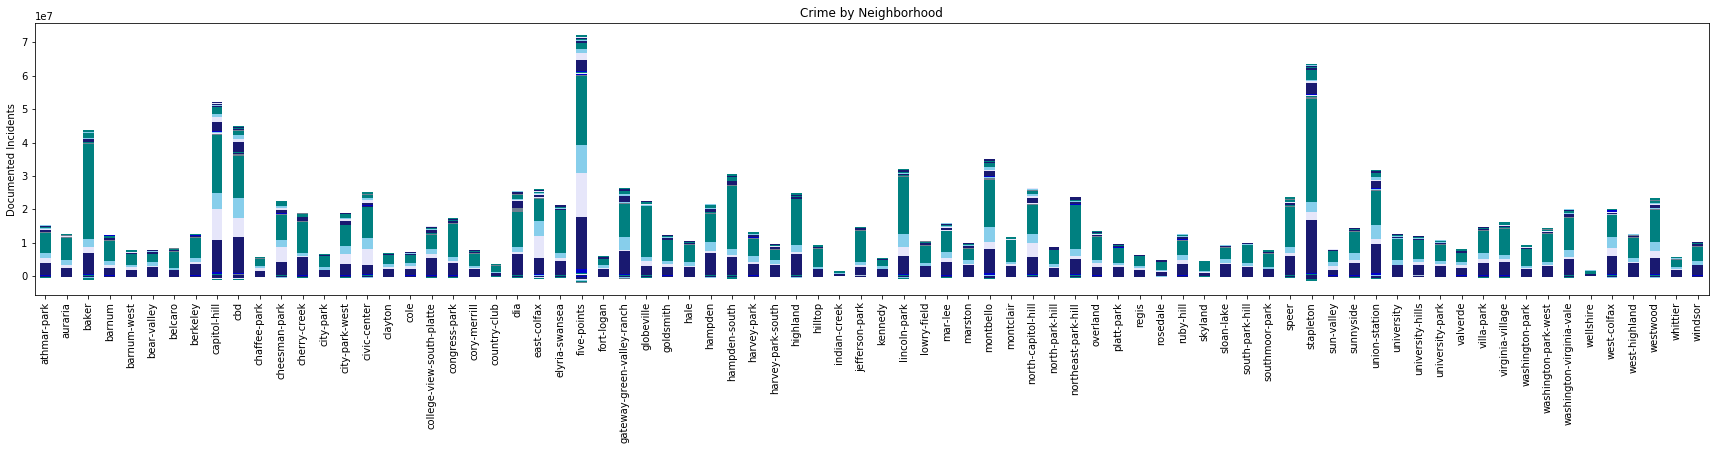

<Figure size 432x288 with 0 Axes>

In [68]:
# Playing with crime by neighborhood -EN

neighborhood_pivot = crime_weather.pivot_table(crime_weather, index='Neighborhood', columns='OFFENSE_CATEGORY_ID', 
                                  aggfunc='sum')

colors = ['mediumblue','lightsteelblue','midnightblue','lavender','blue','skyblue','teal','slategrey']

neighborhood_pivot.plot.bar(stacked=True, color=colors, figsize=(30,5), legend=None)
plt.xlabel("")
plt.ylabel("Documented Incidents")
plt.title("Crime by Neighborhood")
plt.show()

plt.savefig("all_neighborhoods.png")

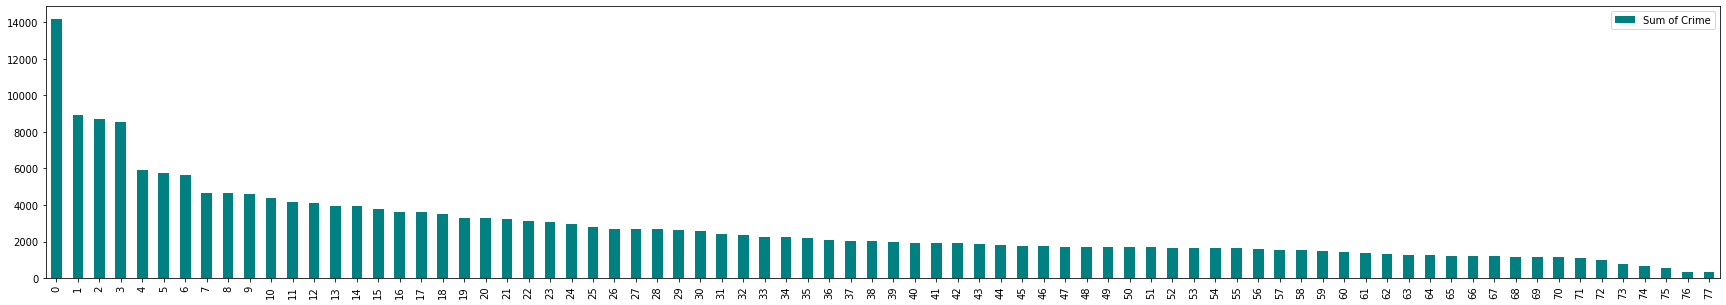

In [69]:
# Playing with crime by neighborhood -EN

groupn_count_df = crime_weather.groupby("Neighborhood").sum()
neighborhood_crime = groupn_count_df["IS_CRIME"].sort_values(ascending=False)

# I can't remember how to convert a groupby index back to numerical so...
crimesum = neighborhood_crime.tolist()
neighborhoods = neighborhood_crime.index.tolist()

# Data Frame with numerical index
ncrime = pd.DataFrame({"Neighborhoods" : neighborhoods, "Sum of Crime" : crimesum})
ncrime

# Bar of all neighborhods
ncrime.plot.bar(colors="teal", figsize=(30,5))

plt.savefig("sorted_neighborhoods.png")

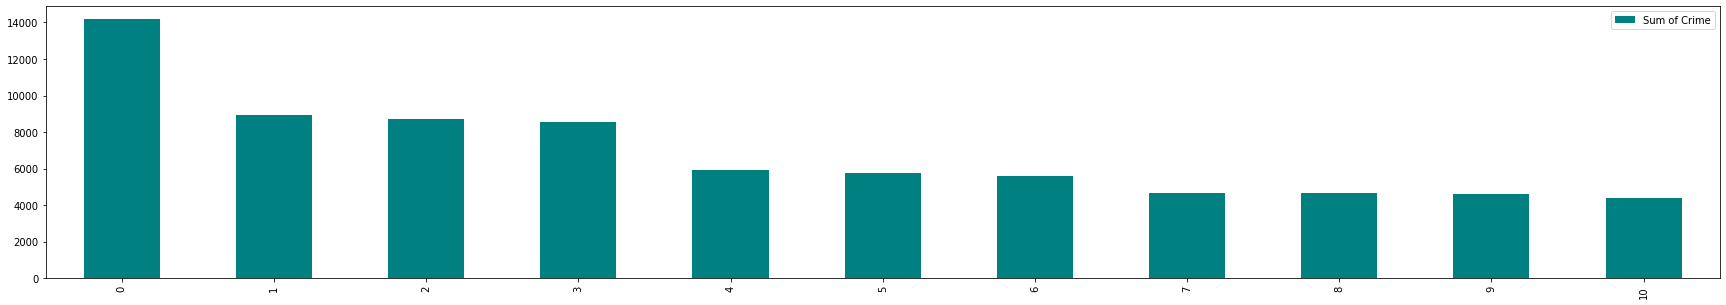

In [70]:
topten_neighborhood_crime = ncrime.iloc[0:11, :]
labels = neighborhoods


topten_neighborhood_crime.plot.bar(colors="teal", figsize=(30,5))

plt.savefig("topten_neighborhoods.png")

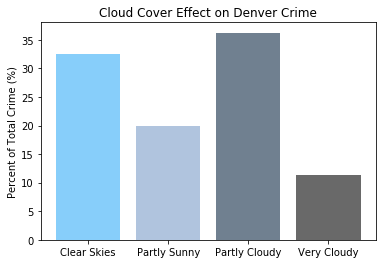

In [71]:
# What is the effect of cloud cover on Denver Crime? -EN

# Binned by cloud cover
bins = [0, 25, 50, 75, 100]
groups = ['Clear Skies', 'Partly Sunny', 'Partly Cloudy', 'Very Cloudy']
crime_weather["Cloud Bins"] = pd.cut(crime_weather["Clouds"], bins, labels=groups)

# Groupby to find sum of crime in each cloudcover bin
cloud_sum = crime_weather.groupby("Cloud Bins").sum()

# Percent of total crime in each cloud cover bin 
cloud_sum["Percent of Total"] = (cloud_sum["IS_CRIME"] / cloud_sum["IS_CRIME"].sum()) * 100

# Cloud cover bar plot
colors = ["lightskyblue", "lightsteelblue", "slategrey", "dimgrey" ]
plt.bar(groups, cloud_sum["Percent of Total"], color=colors, alpha=1, align="center",)
plt.ylabel("Percent of Total Crime (%)")
plt.title("Cloud Cover Effect on Denver Crime")

plt.savefig("cloudy_crime.png")

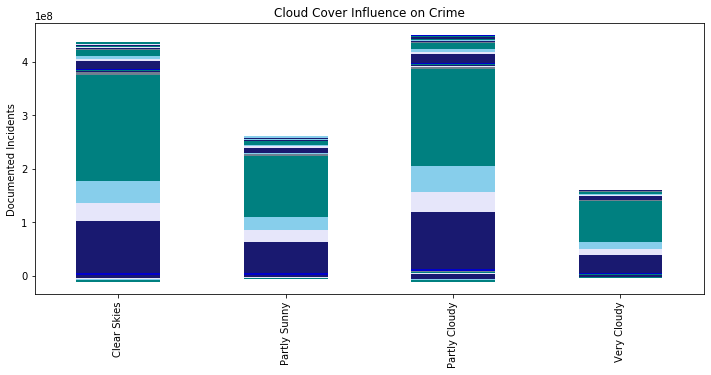

<Figure size 432x288 with 0 Axes>

In [72]:
# Playing with crime by cloud cover -EN

# Cloud pivot
cloud_pivot = crime_weather.pivot_table(crime_weather, index='Cloud Bins', columns='OFFENSE_CATEGORY_ID', 
                                  aggfunc='sum')

# Cloud cover stacked
colors = ['mediumblue','lightsteelblue','midnightblue','lavender','blue','skyblue','teal','slategrey']
cloud_pivot.plot.bar(stacked=True, color=colors, figsize=(12,5), legend=None)
plt.xlabel("")
plt.ylabel("Documented Incidents")
plt.title("Cloud Cover Influence on Crime")
plt.show()

plt.savefig("cloudy_crime_stacked.png")

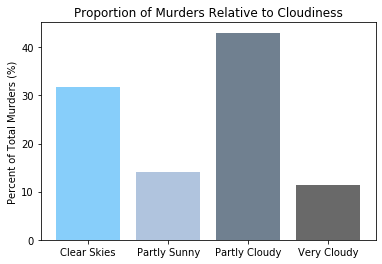

In [73]:
# Cloudy murders -EN

cloudy_murders = crime_weather[crime_weather["OFFENSE_CATEGORY_ID"] == "Murder"]

# Groupby to find sum of crime in each cloudcover bin
cloudy_murder_sum = cloudy_murders.groupby("Cloud Bins").sum()

# Percent of total crime in each cloud cover bin 
cloudy_murder_sum["Percent of Total"] = (cloudy_murder_sum["IS_CRIME"] / cloudy_murder_sum["IS_CRIME"].sum()) * 100

# Cloudy Murders Bar Plot
colors = ["lightskyblue", "lightsteelblue", "slategrey", "dimgrey" ]
plt.bar(groups, cloudy_murder_sum["Percent of Total"], color=colors, alpha=1, align="center",)
plt.ylabel("Percent of Total Murders (%)")
plt.title("Proportion of Murders Relative to Cloudiness")

plt.savefig("cloudy_murder.png")

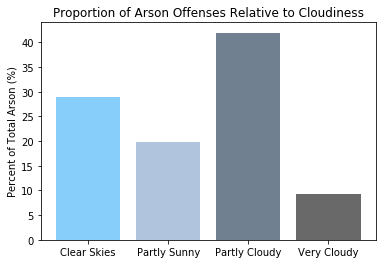

In [74]:
# Cloudy arson -EN

cloudy_arson = crime_weather[crime_weather["OFFENSE_CATEGORY_ID"] == "Arson"]

# Groupby to find sum of crime in each cloudcover bin
cloudy_arson_sum = cloudy_arson.groupby("Cloud Bins").sum()

# Percent of total crime in each cloud cover bin 
cloudy_arson_sum["Percent of Total"] = (cloudy_arson_sum["IS_CRIME"] / cloudy_arson_sum["IS_CRIME"].sum()) * 100

# Cloudy Murders Bar Plot
colors = ["lightskyblue", "lightsteelblue", "slategrey", "dimgrey" ]
plt.bar(groups, cloudy_arson_sum["Percent of Total"], color=colors, alpha=1, align="center",)
plt.ylabel("Percent of Total Arson (%)")
plt.title("Proportion of Arson Offenses Relative to Cloudiness")

plt.savefig("cloudy_arson.png")

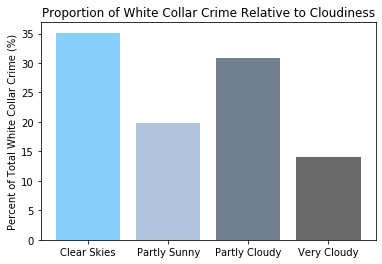

In [75]:
# Cloudy white collar crime -EN

cloudy_wcc = crime_weather[crime_weather["OFFENSE_CATEGORY_ID"] == "White Collar Crime"]

# Groupby to find sum of crime in each cloudcover bin
cloudy_wcc_sum = cloudy_wcc.groupby("Cloud Bins").sum()

# Percent of total crime in each cloud cover bin 
cloudy_wcc_sum["Percent of Total"] = (cloudy_wcc_sum["IS_CRIME"] / cloudy_wcc_sum["IS_CRIME"].sum()) * 100

# Cloudy Murders Bar Plot
colors = ["lightskyblue", "lightsteelblue", "slategrey", "dimgrey" ]
plt.bar(groups, cloudy_wcc_sum["Percent of Total"], color=colors, alpha=1, align="center",)
plt.ylabel("Percent of Total White Collar Crime (%)")
plt.title("Proportion of White Collar Crime Relative to Cloudiness")

plt.savefig("cloudy_whitecollarcrime.png")

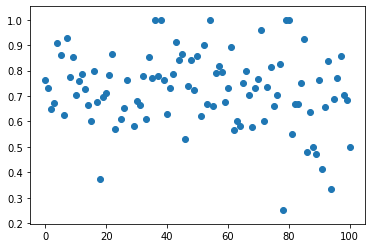

In [88]:
# Average number of crimes relative to cloud index
# cloud_group = crime_weather.groupby("Clouds").mean()
# clouds = crime_weather["Clouds"].unique()

# plt.scatter(clouds,cloud_group["IS_CRIME"])